In [1]:
from utility_data import *

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

## Prepare Data

In [2]:
# maybe go higher (start at 44.1 kHz, go higher 48-96 kHz if needed)
audio_params = {'sample_rate': 44000, 'n_fft': 1024, 'hop_length': 256, 'n_mfcc': 64, 'n_mels': 64, 'feature_size': 1024} # 316?

dataset = AudioDataset(
    datafolder="data",
    metadata_csv="train.csv",
    audio_dir="train_audio",
    extract_features=True,
    audio_params=audio_params
)

## Build a Model

In [3]:
class MelCNN(pl.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 128, 316]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),            # [B, 32, 64, 158]
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 64, 158]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),            # [B, 64, 32, 79]
            nn.Dropout(0.2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1), # [B, 64, 32, 79]
            nn.ReLU(),
        )

        flattened_size = 64 * 32 * 128

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

## Training

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=7)
val_loader = DataLoader(val_set, batch_size=32, num_workers=7)

model = MelCNN(num_classes=len(dataset.classes))

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='{epoch}-{val_loss:.2f}'
)
trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 56.3 K | train
1 | classifier  | Sequential | 16.8 M | train
---------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   2%|▏         | 14/715 [02:33<2:08:29,  0.09it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:   4%|▍         | 28/715 [04:11<1:43:00,  0.11it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:   6%|▌         | 42/715 [05:21<1:25:58,  0.13it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:  10%|█         | 75/715 [09:41<1:22:45,  0.13it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:  20%|█▉        | 140/715 [17:01<1:09:54,  0.14it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:  39%|███▉      | 282/715 [59:40<1:31:37,  0.08it/s, v_num=3]

/Users/tommasoferracina/tommaso/quercia/birdclef2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 0:  53%|█████▎    | 382/715 [1:43:07<1:29:53,  0.06it/s, v_num=3]


Detected KeyboardInterrupt, attempting graceful shutdown ...


: 

# Evaluation


## Version Details

Version 0. Baseline, fed in raw spectrogram data. 

`Performance: Abysmal`


Version 1. Increased to 3 input channels. Fed in audio feature data (mels, mfccs, chromas, spectralbw) 

`Performance: Still poor + overfitting`

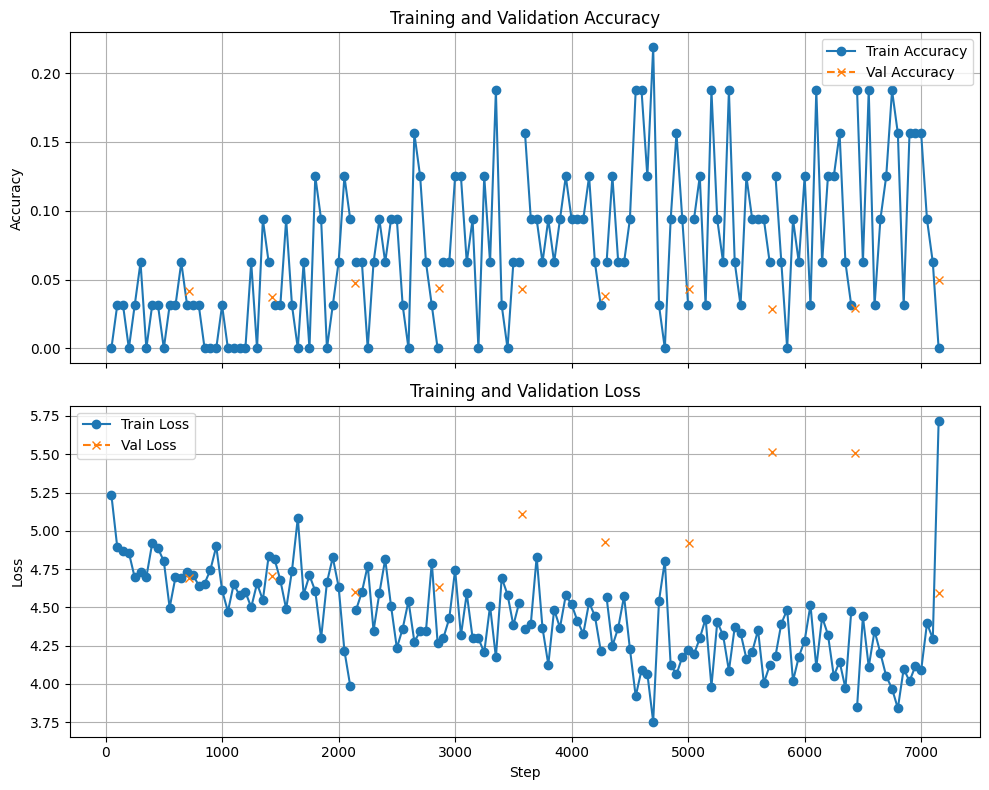

In [ ]:
plot_training_log('lightning_logs/version_0/metrics.csv')

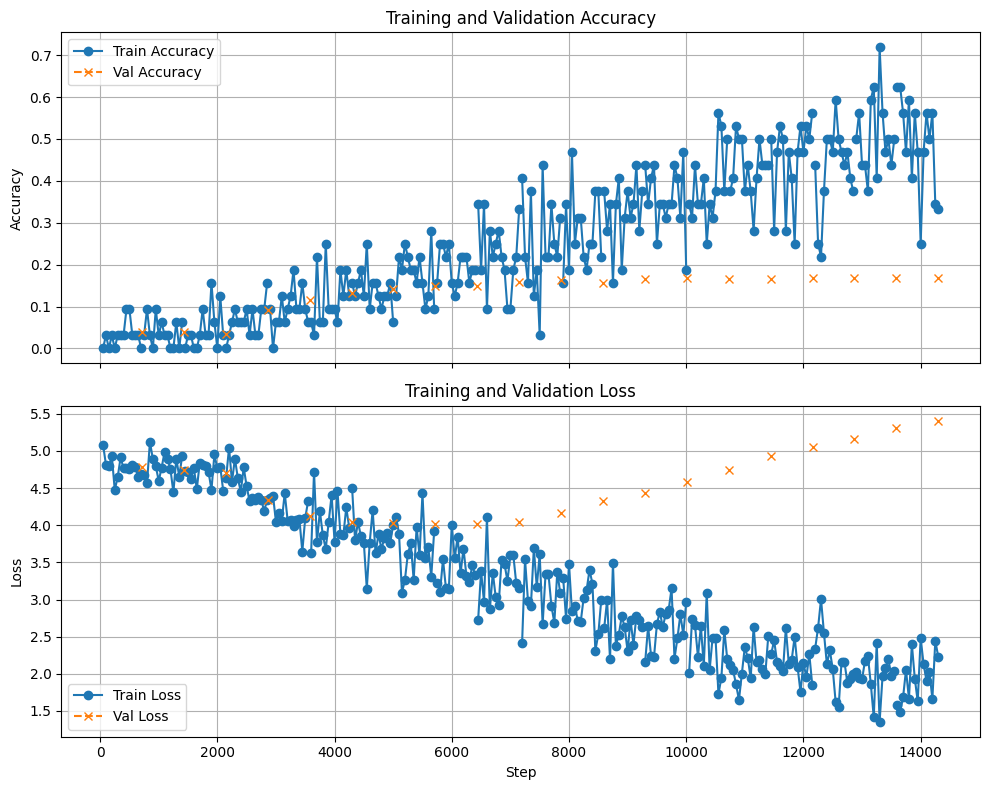

In [ ]:
plot_training_log('lightning_logs/version_1/metrics.csv')

Very clear signs of overfitting. Why? Val loss decreases but then increases after 6000 steps.


Solution:
- introduce early stopping
- simplify model
- implement data augmentation